In [1]:
!pip install torch Pillow matplotlib accelerate bitsandbytes
#!pip install textgrad
!pip install transformers==4.49.0
!pip install torch
!pip install torchmetrics
!pip install torch_optimizer
!pip install hpsv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
import torch
from transformers import (
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    AutoTokenizer,
    AutoModelForCausalLM,
    BlipForConditionalGeneration,
    BlipProcessor,
    BitsAndBytesConfig,
    AutoProcessor,
    AutoModelForImageTextToText
)
from peft import get_peft_model, LoraConfig
from huggingface_hub import login
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import io
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


# BLIP 모델
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

# vit-gpt2 모델
vit_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to("cuda")
vit_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vit_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Florence-2
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large",#base or large
    trust_remote_code=True,
    torch_dtype=torch.float16  # 또는 float32
).to(device)

florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large",
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id"

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [3]:
def generate_caption(image, model_type="blip"):
    if image.mode != "RGB":
        image = image.convert("RGB")

    if model_type == "blip":
        inputs = blip_processor(image, return_tensors="pt").to("cuda")
        outputs = blip_model.generate(**inputs, max_length=50)
        return blip_processor.decode(outputs[0], skip_special_tokens=True)

    elif model_type == "vit-gpt2":
        pixel_values = vit_processor(images=image, return_tensors="pt").pixel_values.to("cuda")
        output_ids = vit_model.generate(pixel_values, max_length=50, num_beams=4)
        return vit_tokenizer.decode(output_ids[0], skip_special_tokens=True)
#textgrad
def florence_feedback(caption, image):
    prompt = f"""Image Caption Enhancement Task:
Original Caption: {caption}
Image Characteristics: {image.size} | Channels: {len(image.getbands())}

Improvement Requests:
1. Accurately identifying each objects.
2. Describing each as if cropped.
3. Considering what the image conveys even when seen out of focus.
4. Improve natural language flow checking sentence before descriptions.

Improved Caption:"""
    # Florence-2는 이미지+텍스트 입력 후 텍스트 생성
    inputs = florence_processor(images=image, text=prompt, return_tensors="pt").to(device)
    inputs = {k: v.half() if v.dtype == torch.float32 else v for k, v in inputs.items()}
    # 실행 속도와 용량을 위해 16bit 짜리 float를 사용
    outputs = florence_model.generate(**inputs, max_new_tokens=100)
    # Florence-2는 processor.decode가 아니라 tokenizer.decode 사용
    improved_caption = florence_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

    return improved_caption.strip()

In [4]:
"""
#평가 시스템
from torchmetrics.multimodal import CLIPScore

class CaptionEvaluator:
    def __init__(self):
        self.clip_metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

    def evaluate(self, image, caption):
        # 이미지 전처리
        processed_image = image.resize((224,224))
        img_tensor = torch.tensor(np.array(processed_image)).permute(2,0,1).unsqueeze(0)

        # CLIP 점수 계산
        score = self.clip_metric(img_tensor, [caption])
        return score.item()
"""

from torchmetrics.multimodal import CLIPScore
import torch
from transformers import AutoProcessor, AutoModel, BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import numpy as np
import hpsv2

class CaptionEvaluator:
    def __init__(self):
        self.clip_metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

        # HPS-V2 모델 초기화
        try:
            # HPS-V2는 직접 import하여 사용
            import hpsv2
            self.hps_available = True
        except ImportError:
            print("HPS-V2 모델을 로드할 수 없습니다. pip install hpsv2 필요")
            self.hps_available = False

        # Pick Score 모델 초기화
        try:
            self.pick_processor = AutoProcessor.from_pretrained("yuvalkirstain/PickScore_v1")
            self.pick_model = AutoModel.from_pretrained("yuvalkirstain/PickScore_v1")
            self.pick_available = True
        except:
            print("Pick Score 모델을 로드할 수 없습니다.")
            self.pick_available = False

        # VQA Score용 BLIP 모델 초기화
        try:
            self.vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
            self.vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
            self.vqa_available = True
        except:
            print("VQA 모델을 로드할 수 없습니다.")
            self.vqa_available = False

    def calculate_hps_score(self, image, caption):
        """HPS-V2 점수 계산"""
        if not self.hps_available:
            return None

        try:
            score = hpsv2.score(image, caption, hps_version="v2.1")
            return score
        except Exception as e:
            print(f"HPS-V2 점수 계산 오류: {e}")
            return None

    def calculate_pick_score(self, image, caption):
        """Pick Score 계산"""
        if not self.pick_available:
            return None

        try:
            # 입력 전처리
            inputs = self.pick_processor(
                images=image,
                text=caption,
                return_tensors="pt",
                padding=True
            )

            with torch.no_grad():
                outputs = self.pick_model(**inputs)
                # Pick Score는 logits의 첫 번째 값을 사용
                score = outputs.logits_per_image.item()

            return score
        except Exception as e:
            print(f"Pick Score 계산 오류: {e}")
            return None

    def calculate_vqa_score(self, image, caption):
        """VQA Score 계산 (캡션 기반 질문-답변 정확도)"""
        if not self.vqa_available:
            return None

        try:
            # 캡션에서 간단한 질문들 생성
            questions = [
                "What is in this image?",
                "What is the main object in the image?",
                "What color is the main object?",
                "What is happening in this image?"
            ]

            correct_answers = 0
            total_questions = len(questions)

            for question in questions:
                # VQA 모델로 답변 생성
                inputs = self.vqa_processor(image, question, return_tensors="pt")

                with torch.no_grad():
                    outputs = self.vqa_model.generate(**inputs, max_length=20)
                    answer = self.vqa_processor.decode(outputs[0], skip_special_tokens=True)

                # 간단한 키워드 매칭으로 정확도 계산
                caption_lower = caption.lower()
                answer_lower = answer.lower()

                # 답변의 주요 단어가 캡션에 포함되어 있는지 확인
                answer_words = answer_lower.split()
                if any(word in caption_lower for word in answer_words if len(word) > 3):
                    correct_answers += 1

            vqa_score = correct_answers / total_questions
            return vqa_score

        except Exception as e:
            print(f"VQA Score 계산 오류: {e}")
            return None

    def evaluate(self, image, caption):
        # 이미지 전처리
        processed_image = image.resize((224,224))
        img_tensor = torch.tensor(np.array(processed_image)).permute(2,0,1).unsqueeze(0)

        # CLIP 점수 계산
        clip_score = self.clip_metric(img_tensor, [caption])

        results = {'clip_score': clip_score.item()}

        # HPS-V2 점수 계산
        hps_score = self.calculate_hps_score(image, caption)
        if hps_score is not None:
            results['hps_score'] = hps_score

        # Pick Score 계산
        pick_score = self.calculate_pick_score(image, caption)
        if pick_score is not None:
            results['pick_score'] = pick_score

        # VQA Score 계산
        vqa_score = self.calculate_vqa_score(image, caption)
        if vqa_score is not None:
            results['vqa_score'] = vqa_score

        # 종합 점수 계산 (사용 가능한 점수들의 평균)
        available_scores = [score for score in [
            results.get('clip_score'),
            results.get('hps_score'),
            results.get('pick_score'),
            results.get('vqa_score')
        ] if score is not None]

        if available_scores:
            results['composite_score'] = sum(available_scores) / len(available_scores)

        return results



In [5]:
#fine tunning
from torch_optimizer import RAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
optimizer = RAdam(model.parameters(), lr=5e-5)
# 학습용 데이터셋 구축
class CaptionDataset(Dataset):
    def __init__(self, images, captions=None, processor=None, tokenizer=None):
        self.images = images
        self.captions = captions or [""] * len(images)
        self.processor = processor
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.processor(images=self.images[idx], return_tensors="pt").pixel_values.squeeze()
        caption = self.tokenizer(self.captions[idx], padding="max_length", truncation=True, max_length=50, return_tensors="pt").input_ids.squeeze()
        return image, caption

def fine_tune_model(image, improved_caption):
    model.train()
    inputs = processor(images=image, return_tensors="pt").pixel_values.to(device)
    labels = tokenizer(improved_caption, return_tensors="pt", padding="max_length", truncation=True, max_length=50).input_ids.to(device)
    outputs = model(pixel_values=inputs, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

#이미지 로드

import os
import zipfile
import requests
from PIL import Image

# 1. COCO 2017 validation 이미지 zip 파일 다운로드
url = "http://images.cocodataset.org/zips/val2017.zip"
zip_path = "val2017.zip"
img_dir = "val2017"

if not os.path.exists(zip_path):
    print("Downloading COCO 2017 val images...")
    r = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

# 2. 압축 해제
if not os.path.exists(img_dir):
    print("Extracting images...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(".")

# 3. 이미지 파일 리스트 가져오기
img_files = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".jpg")]

# 4. PIL 이미지 리스트 만들기 (최대 5000장)
images = []
for img_path in img_files[:10]:  # 필요시 [:100] 등으로 조절
    img = Image.open(img_path).convert("RGB")
    images.append(img)

print(f"총 {len(images)}장의 이미지를 불러왔습니다.")

import torchvision.transforms as transforms

to_pil = transforms.ToPILImage()

captions = [generate_caption(img, model_type="blip") for img in images]
dataset = CaptionDataset(images, captions, processor, tokenizer)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(3):
    for image_tensor, caption in dataset:
        image = to_pil(image_tensor)
        initial_caption = generate_caption(image)
        improved_caption = florence_feedback(initial_caption, image)
        fine_tune_model(image, improved_caption)


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id"

Extracting images...
총 10장의 이미지를 불러왔습니다.


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [6]:
def optimize_caption(image, max_iter=3):
    evaluator = CaptionEvaluator()

    # 초기 캡션 생성
    base_caption = generate_caption(image, model_type="blip")
    best_score = evaluator.evaluate(image, base_caption)
    best_caption = base_caption

    #print(f"초기 캡션: {base_caption} | 점수: {best_score:.2f}")

    # 반복적 개선
    for i in range(max_iter):
        new_caption = florence_feedback(best_caption, image)
        #gradient_caption = florence_feedback(best_caption, image)
        #inputs = florence_processor(images=image, text=gradient_caption, return_tensors="pt").to(device)
        #inputs = {k: v.half() if v.dtype == torch.float32 else v for k, v in inputs.items()}
        #new_caption = florence_model.generate(**inputs, max_new_tokens=200)
        current_score = evaluator.evaluate(image, new_caption)

        if current_score > best_score:
            best_score = current_score
            best_caption = new_caption
            print(f"updated at {i+1}: {new_caption} | score: {current_score:.2f}")

    return best_caption

In [7]:
# 테스트 이미지 로드
def load_image(url):
    response = requests.get(url)
    return Image.open(io.BytesIO(response.content))
"""
test_image = load_image("https://images.unsplash.com/photo-1583512603805-3cc6b41f3edb")

# 최적화 실행
final_caption = optimize_caption(test_image)
print("\n최종 결과:", final_caption)

# 결과 시각화
plt.figure(figsize=(10,10))
plt.imshow(test_image)
plt.title(f"최적화된 캡션:\n{final_caption}", wrap=True)
plt.axis('off')
plt.show()
"""

'\ntest_image = load_image("https://images.unsplash.com/photo-1583512603805-3cc6b41f3edb")\n\n# 최적화 실행\nfinal_caption = optimize_caption(test_image)\nprint("\n최종 결과:", final_caption)\n\n# 결과 시각화\nplt.figure(figsize=(10,10))\nplt.imshow(test_image)\nplt.title(f"최적화된 캡션:\n{final_caption}", wrap=True)\nplt.axis(\'off\')\nplt.show()\n'

In [8]:
def generate_caption_finetuned(image):
      device = "cuda" if torch.cuda.is_available() else "cpu"
      model.eval()
      pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
      with torch.no_grad():
          output_ids = model.generate(pixel_values, max_length=50, num_beams=4)
      caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
      return caption

In [9]:
def comparative_analysis(image):
    models = ["blip", "vit-gpt2"]
    results = {}
    evaluator = CaptionEvaluator()

    for model_import in models:
        caption = generate_caption(image, model_import)
        result = evaluator.evaluate(image, caption)
        results[model_import] = {"caption": caption, "CLIP_Score": result.get('clip_score', 'N/A'), "HPS_Score": result.get('hps_score', 'N/A'), "Pick_Score": result.get('pick_score', 'N/A'), "VQA_Score": result.get('vqa_score', 'N/A'), "Composite_Score": result.get('composite_score', 'N/A')}

    banila = optimize_caption(image, max_iter=0)
    banila_result = evaluator.evaluate(image, banila)
    results["Florence-2"] = {"caption": banila, "CLIP_Score": banila_result.get('clip_score', 'N/A'), "HPS_Score": banila_result.get('hps_score', 'N/A'), "Pick_Score": banila_result.get('pick_score', 'N/A'), "VQA_Score": banila_result.get('vqa_score', 'N/A'), "Composite_Score": banila_result.get('composite_score', 'N/A')}
    # Florence 기반 최적화
    #optimized = optimize_caption(image, max_iter=10)
    #opt_score = evaluator.evaluate(image, optimized)
    #results["optimized"] = {"caption": optimized, "score": opt_score}

    # fine-tuned 모델 결과
    finetuned_caption = generate_caption_finetuned(image)
    finetuned_result = evaluator.evaluate(image, finetuned_caption)
    results["finetuned"] = {"caption": finetuned_caption, "CLIP_Score": finetuned_result.get('clip_score', 'N/A'), "HPS_Score": finetuned_result.get('hps_score', 'N/A'), "Pick_Score": finetuned_result.get('pick_score', 'N/A'), "VQA_Score": finetuned_result.get('vqa_score', 'N/A'), "Composite_Score": finetuned_result.get('composite_score', 'N/A')}


    # 결과 시각화
    fig, axs = plt.subplots(1, len(results) + 1, figsize=(25, 5))
    axs[0].imshow(image)
    axs[0].set_title("original image")
    axs[0].axis('off')

    for idx, (name, data) in enumerate(results.items(), 1):
        axs[idx].imshow(image)
        axs[idx].set_title(f"{name}\nCLIP_Score: {data['CLIP_Score']:.2f}\nPick_Score: {data['Pick_Score']:.2f}\nVQA_Score: {data['VQA_Score']:.2f}\nComposite_Score: {data['Composite_Score']:.2f}\n")
        axs[idx].text(0, -50, data['caption'], wrap=True)
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


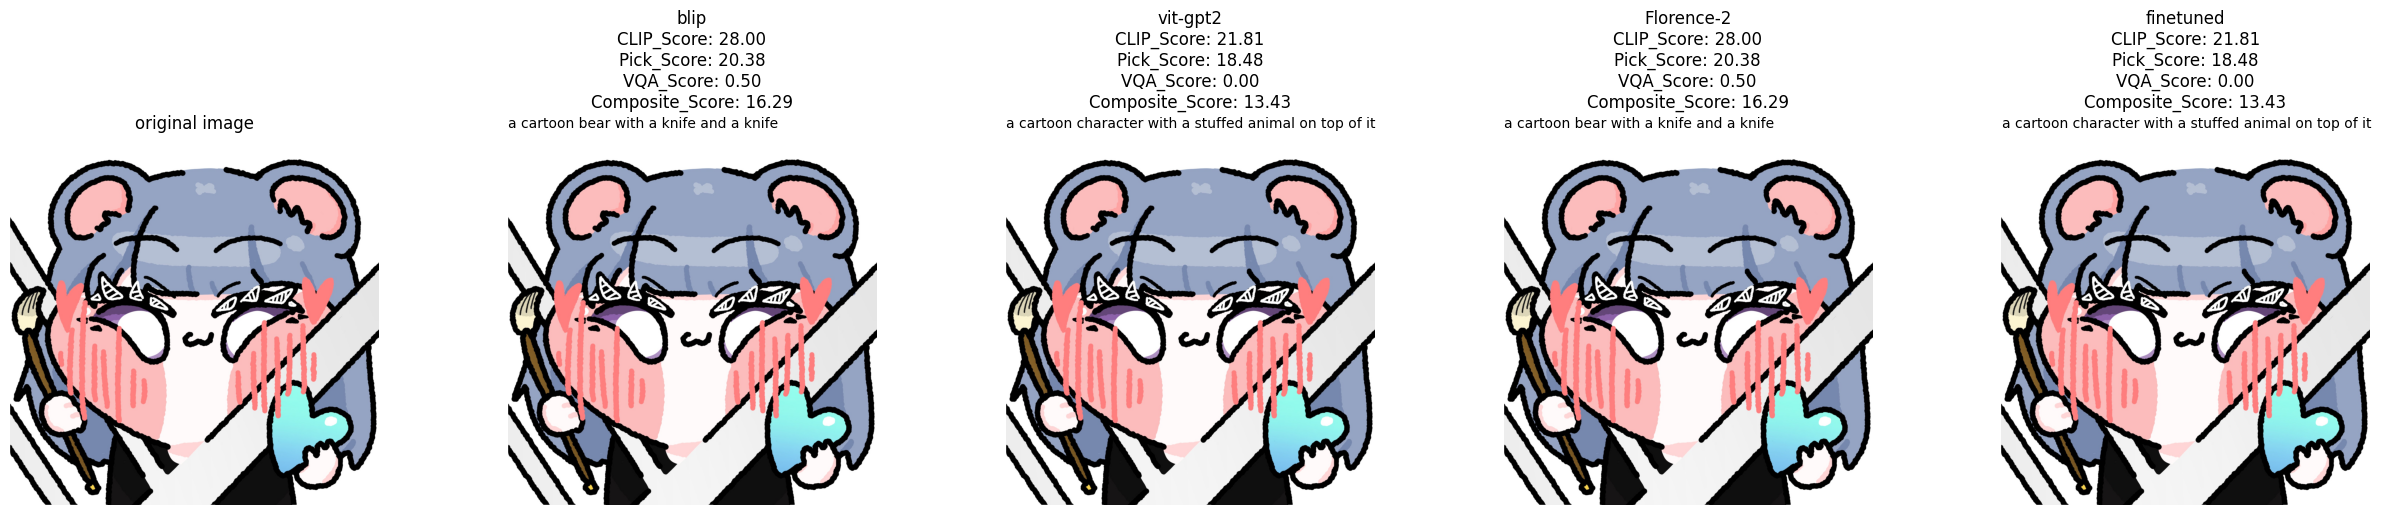

In [10]:
test_image = load_image("https://pbs.twimg.com/media/Gq_RCtfWUAEsxoC?format=jpg&name=large")

comparative_analysis(test_image)

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


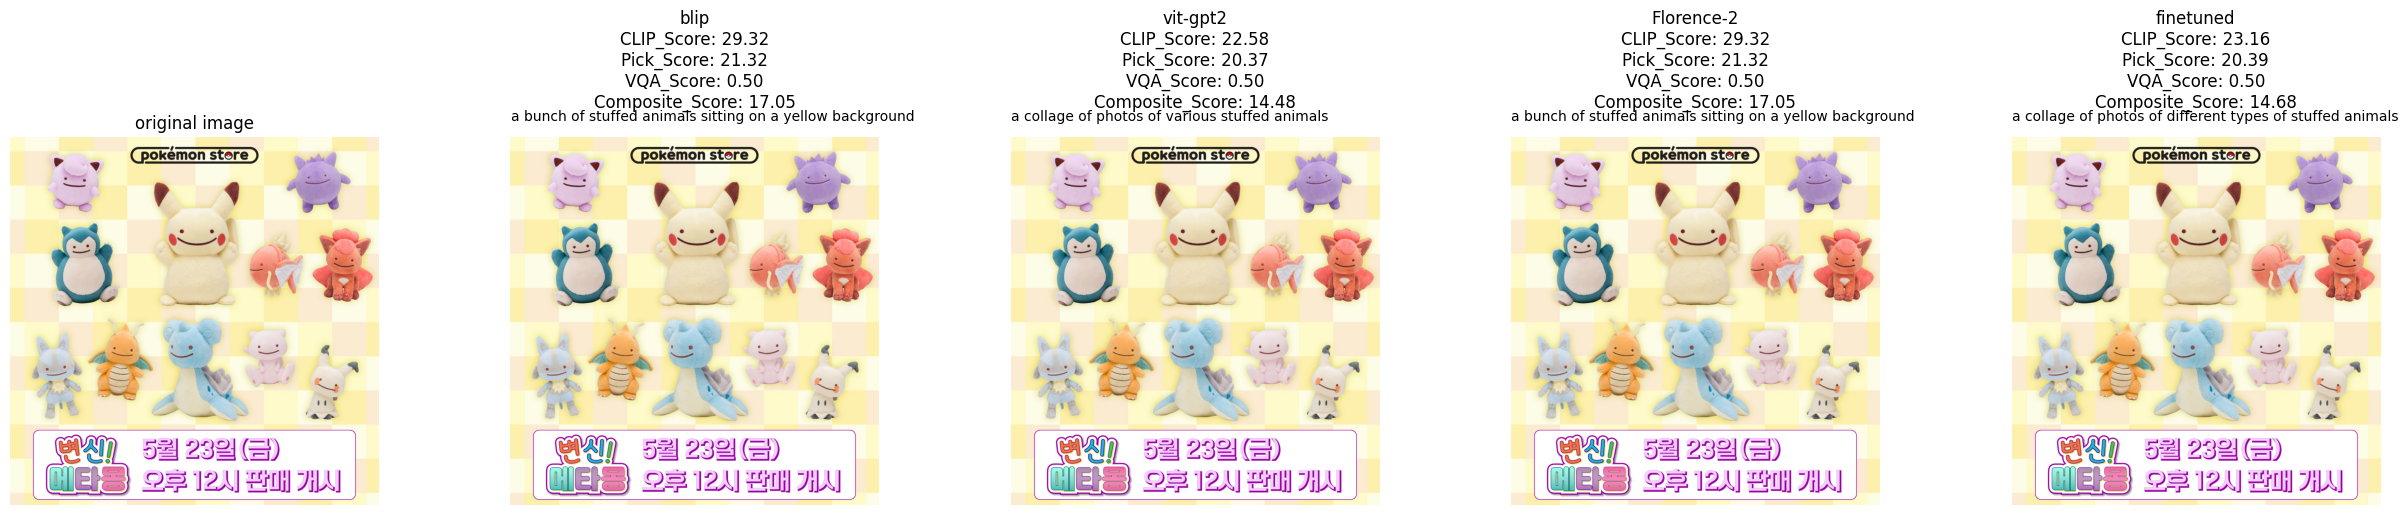

In [11]:
test_image = load_image("https://pbs.twimg.com/media/GrDxQPibgAAz862?format=jpg&name=medium")

comparative_analysis(test_image)

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


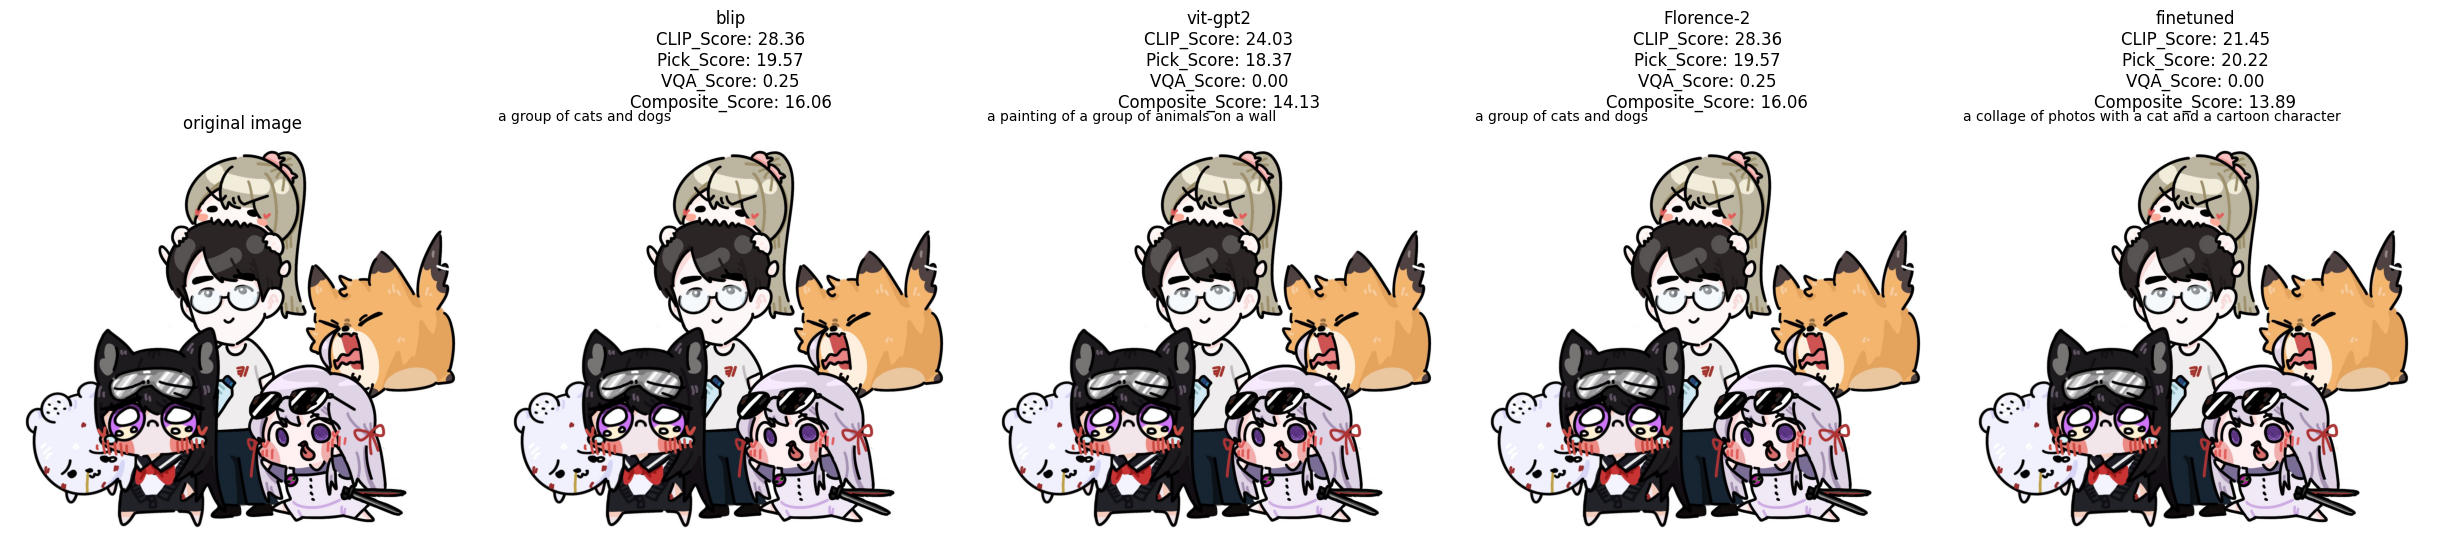

In [12]:
test_image = load_image("https://pbs.twimg.com/media/GksdDm_XAAAx705?format=jpg&name=large")

comparative_analysis(test_image)

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


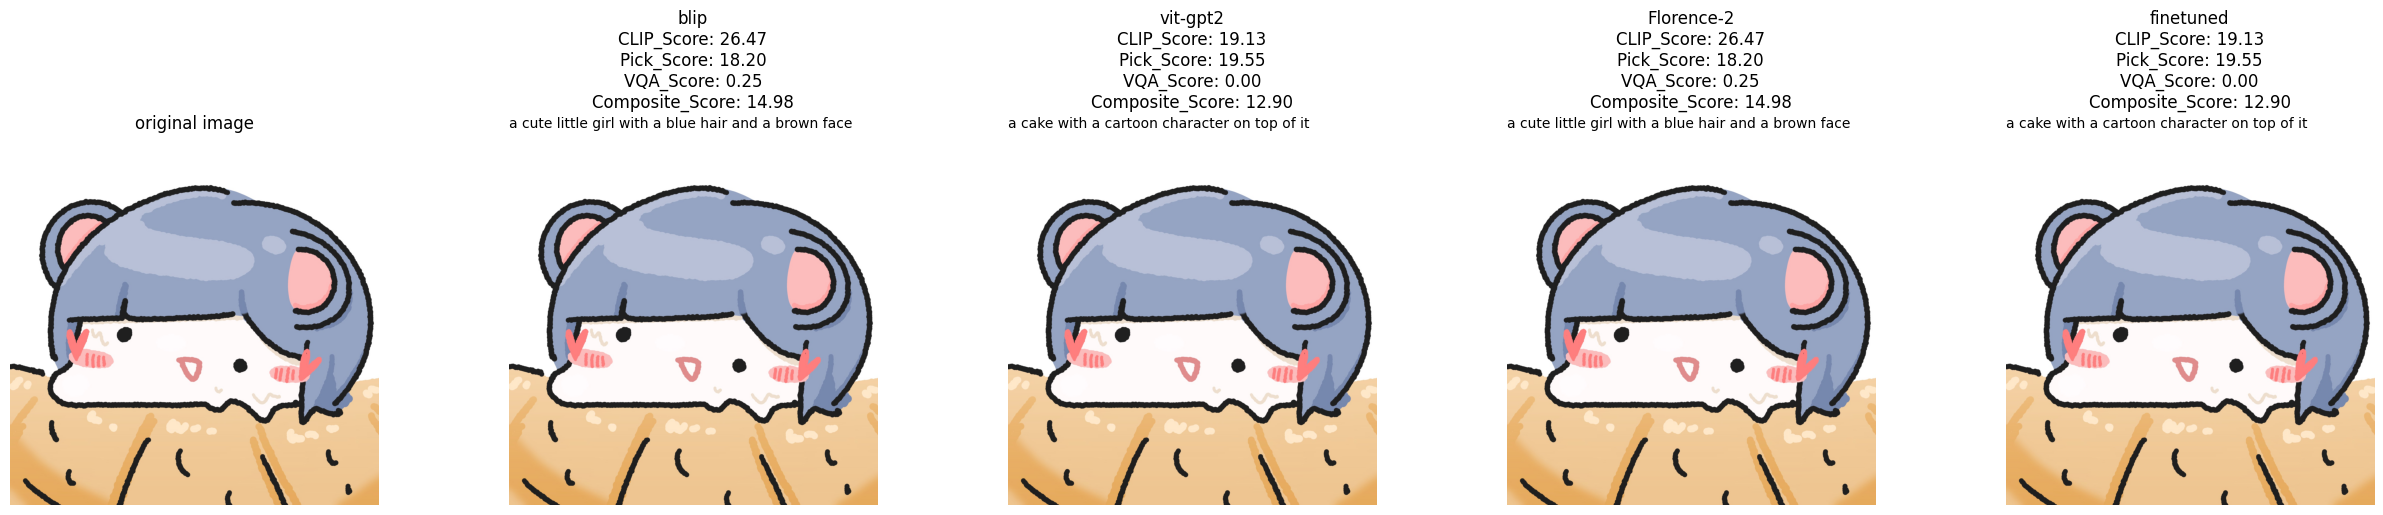

In [13]:
test_image = load_image("https://pbs.twimg.com/media/GrYrYt3bAAEdp-z?format=jpg&name=large")

comparative_analysis(test_image)

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


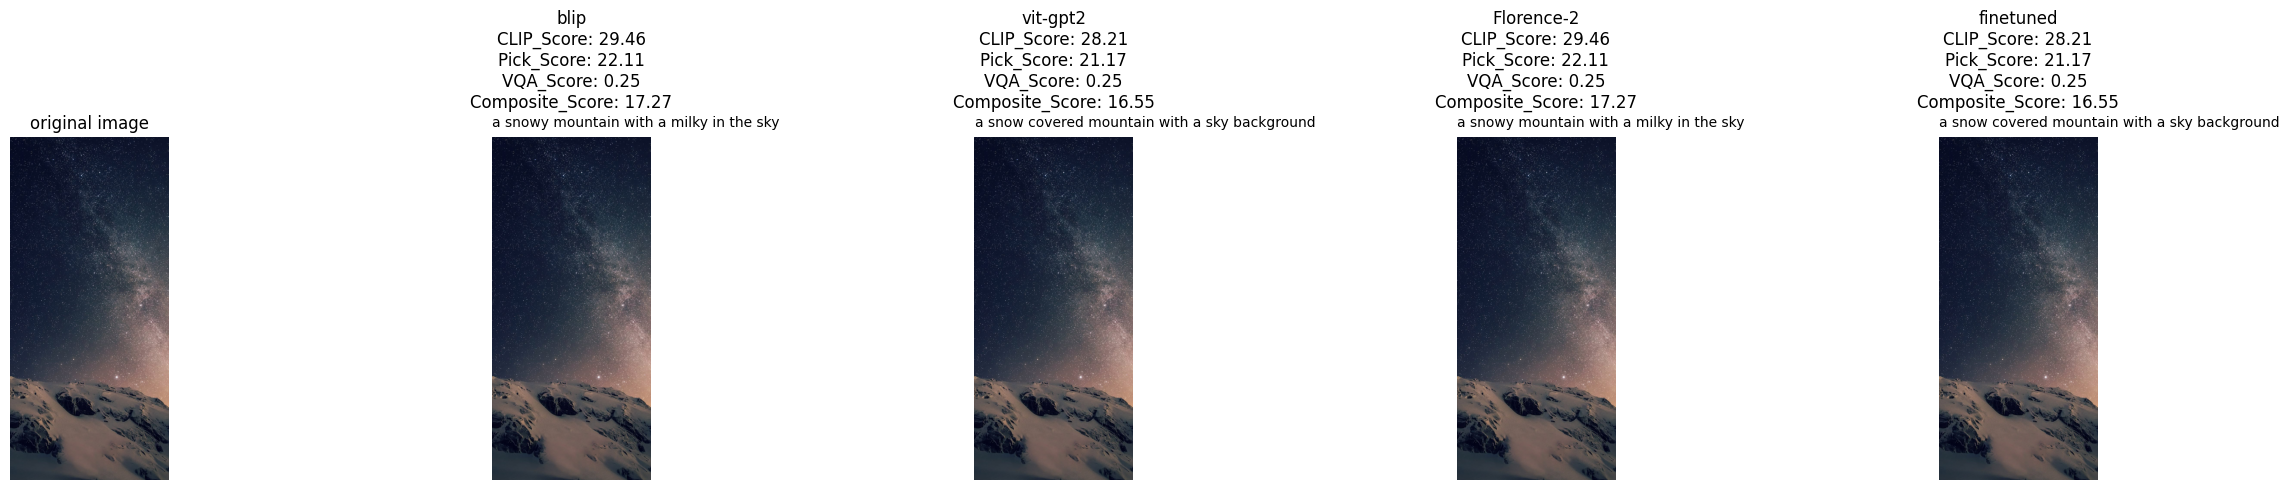

In [14]:
test_image = load_image("https://pbs.twimg.com/media/GtVfY2EWcAAdxzS?format=jpg&name=large")

comparative_analysis(test_image)

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


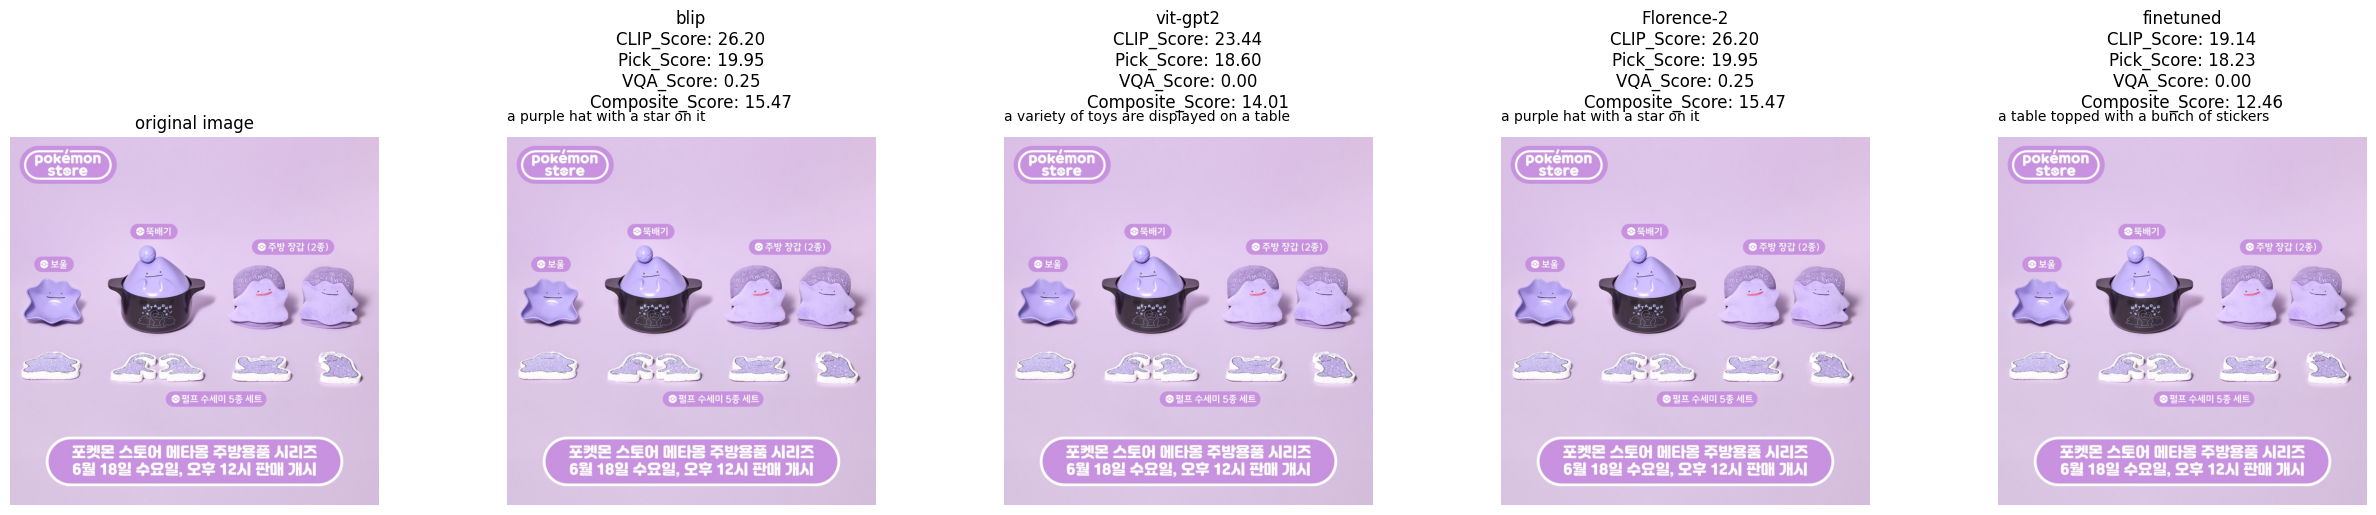

In [15]:
test_image = load_image("https://pbs.twimg.com/media/GtOTH4wakAElbhy?format=jpg&name=medium")

comparative_analysis(test_image)

HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'
HPS-V2 점수 계산 오류: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/hpsv2/src/open_clip/bpe_simple_vocab_16e6.txt.gz'


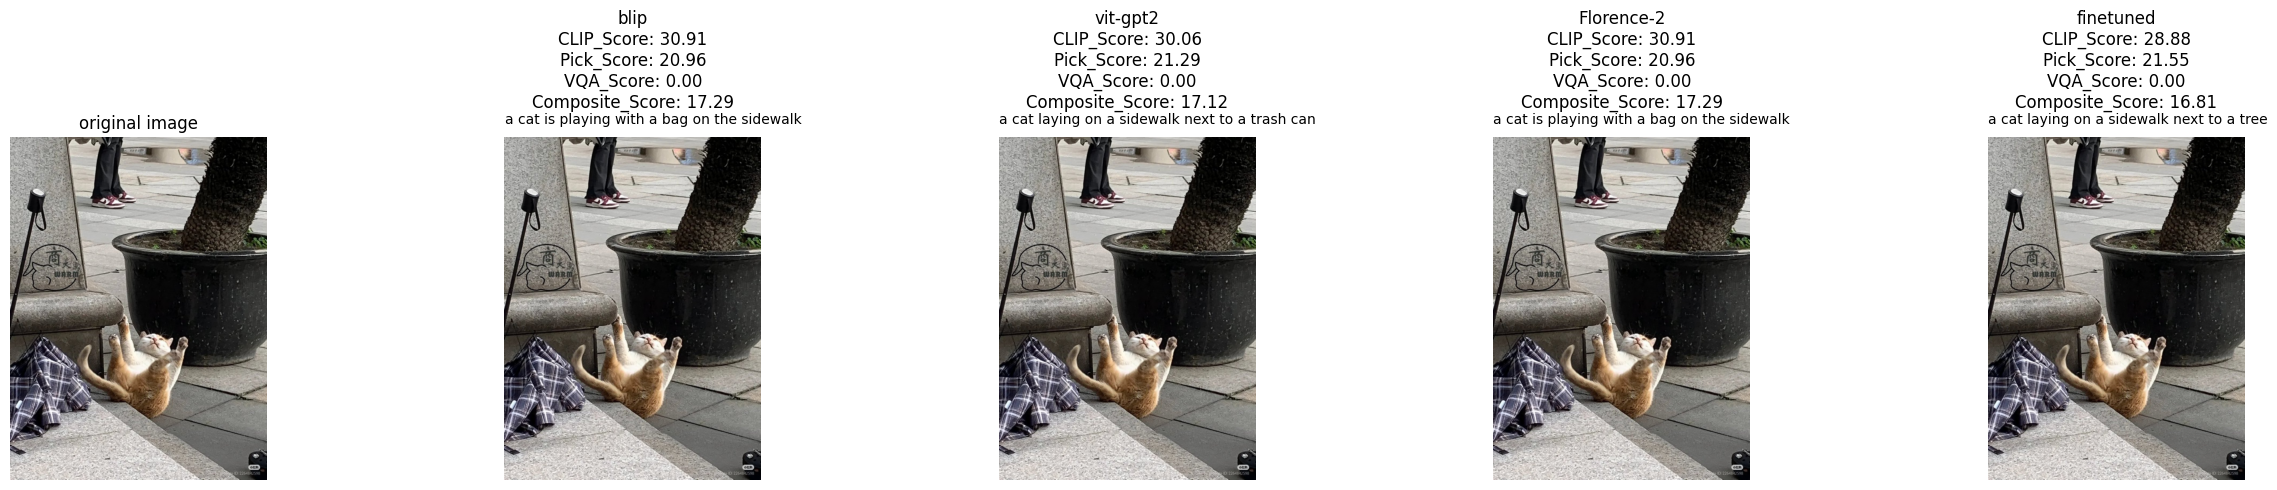

In [16]:
test_image = load_image("https://pbs.twimg.com/media/GtVL6gnX0AA7zEq?format=jpg&name=large")

comparative_analysis(test_image)